<a href="https://colab.research.google.com/github/shahdhruv29/mnist-classification-lenet5-pytorch/blob/main/mlp_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Implemented the LeNet-5 Architecture to train the MNIST dataset.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the train data

df=pd.read_csv('/content/drive/MyDrive/MNIST/mnist_train.csv')
print(df.shape)

#Convert df to pytorch tensor
data=df.values
print(type(data))
# print(data.shape)

(60000, 785)
<class 'numpy.ndarray'>


In [ ]:
#Convert to torch tensors
Transform = transforms.ToTensor()
Data=Transform(data)
print(Data.shape)

#Seperate the data and labels
X=Data[0,:,1:]
Y=Data[0,:,0:1]
print(X.shape)
print(Y.shape)  


#Visualize the data
img, label = X[0,:], Y[0,0]
print(img.shape, label)

torch.Size([1, 60000, 785])
torch.Size([60000, 784])
torch.Size([60000, 1])
torch.Size([784]) tensor(5)


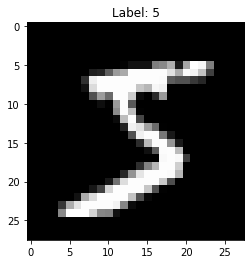

In [ ]:
plt.imshow(img.reshape(28,28), cmap='gray')
plt.title('Label: '+str(label.item()))
plt.show()

In [ ]:
#Resize each image to 28x28
X=X.reshape(60000,28,28) #60000 images of 28x28
print(X.shape)
# print(type(X))

#Add padding to make the image 32x32
X=torch.nn.functional.pad(X, (2,2,2,2), 'constant', 0)
print(X.shape)

torch.Size([60000, 28, 28])
torch.Size([60000, 32, 32])


In [ ]:
#Normalize the data
X.type(torch.float32)
mean=torch.mean(X.type(torch.float32))
std=torch.std(X.type(torch.float32))
X = (X-mean)/std 
print(X.shape)

torch.Size([60000, 32, 32])


In [ ]:
batch_size=8
num_classes=10

train_loader = torch.utils.data.DataLoader(dataset=X, batch_size=batch_size, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Now we will try to implement the LeNet-5 Architecture

In [ ]:
#Build a LeNet-5 model with ReLU 
class LeNet5(nn.Module):
    def __init__(self) :
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,6,kernel_size=5,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6,16,kernel_size=5,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16,120,kernel_size=5,stride=1,padding=0),
        )

        self.fc=nn.Linear(120,84)
        self.relu=nn.ReLU()
        self.fc1=nn.Linear(84,10)
    
    def forward(self, x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=out.reshape(out.size(0),-1)
        out=self.fc(out)
        out=self.relu(out)
        out=self.fc1(out)
        return out

In [ ]:
#Setting the loss function and optimizer
model = LeNet5().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc): Linear(in_features=120, out_features=84, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=84, out_features=10, bias=True)
)


NOW WE WILL TRAIN THE MODEL WE DESIGNED ABOVE

In [ ]:
#Training the model
total_step = len(train_loader)
num_epochs = 5
acc_history = []
loss_history = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    running_loss = 0.0
    running_corrects = 0
    
    for i in range(total_step):
        # print(X[i].shape)
        images = X[i].reshape(1,1,32,32).to(device)
        # print(images.shape)
        labels = Y[i,:].to(device)
        # print(labels.shape)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / total_step
    epoch_acc = running_corrects.double() / total_step

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
        

Epoch 0/4
----------
Loss: 0.3028 Acc: 0.9073
Epoch 1/4
----------
Loss: 0.1645 Acc: 0.9525
Epoch 2/4
----------
Loss: 0.1353 Acc: 0.9624
Epoch 3/4
----------
Loss: 0.1226 Acc: 0.9649
Epoch 4/4
----------
Loss: 0.1125 Acc: 0.9719


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/MNIST/mlp_model1.pkl')

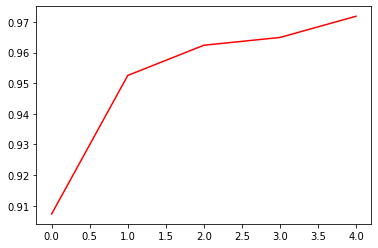

In [ ]:
plt.plot(acc_history, color='r')

In [ ]:
#Loading the test data
df2=pd.read_csv('/content/drive/MyDrive/MNIST/mnist_test.csv')
print(df2.shape)

#Convert df to pytorch tensor
data2=df2.values
print(type(data2))
# print(data.shape)

(10000, 785)
<class 'numpy.ndarray'>


In [ ]:
#Convert to torch tensors
Transform = transforms.ToTensor()
Data2=Transform(data2)
# Y=Transform(data[:,0])
print(Data2.shape)

#Seperate the data and labels
X_test=Data2[0,:,1:]
Y_test=Data2[0,:,0:1]
print(X_test.shape)
print(Y_test.shape)

#Resize each image to 28x28
X_test=X_test.reshape(-1,28,28) #10000 images of 28x28
print(X_test.shape)

#Add padding to make the image 32x32
X_test=torch.nn.functional.pad(X_test, (2,2,2,2), 'constant', 0)
print(X_test.shape)

torch.Size([1, 10000, 785])
torch.Size([10000, 784])
torch.Size([10000, 1])
torch.Size([10000, 28, 28])
torch.Size([10000, 32, 32])


In [ ]:
# X_test.type(torch.float32)
mean=torch.mean(X_test.type(torch.float32))
std=torch.std(X_test.type(torch.float32))
X_test = (X_test-mean)/std 
print(X_test.shape)

torch.Size([10000, 32, 32])


In [ ]:
#Testing the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    pred_list = []
    true_list = []

    for i in range(len(X_test)):
        images = X_test[i].reshape(1,1,32,32).to(device)
        labels = Y_test[i,:].to(device)
        outputs = model(images)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        pred_list.append(predicted.cpu().numpy())
        true_list.append(predicted.cpu().numpy())

    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 95.91 %


Text(69.0, 0.5, 'Truth')

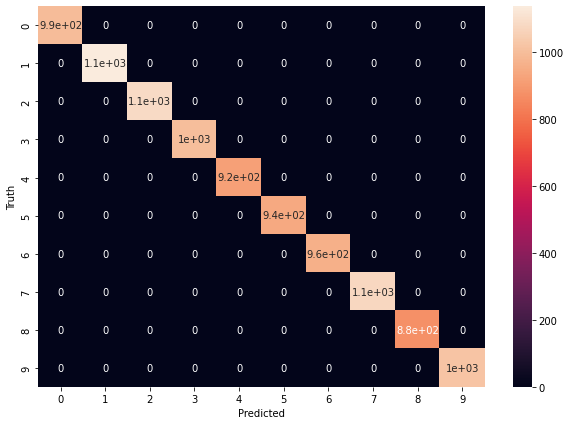

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_list, pred_list)
# print(cm)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')